In [3]:
import numpy as np 
import scipy.stats 
from scipy.misc import logsumexp
epsilon = 1e-6


class NBC(object):
    
    def __init__(self,feature_types=['b','r','b'],num_classes=4):
        self.feature_types = np.array(feature_types)
        self.num_classes = num_classes
        self.num_features = len(feature_types)
        self.alphab = 1 
        self.alpham = 1 
    
    def fit(self,X,y):
        self.classes, counts = np.unique(y, return_counts=True)
        self.class_prior_ = counts/float(len(y))   
        posClassMap = dict(enumerate(self.classes))
        classPosMap = dict ((j,i) for (i,j) in enumerate(self.classes))
  
#         if len(self.classes) != self.num_classes: 
#             raise ValueError("Number of classes given is not equal to number of unique classes observed in training data")
        
        self.real_features = np.where(self.feature_types == 'r')[0]
        self.binary_features = np.where(self.feature_types == 'b')[0]
        self.multivariate_features = np.where(self.feature_types == 'm')[0]
        
        self.mean_ = np.zeros((self.num_classes,len(self.real_features)))
        self.var_ = np.zeros((self.num_classes,len(self.real_features)))  
        self.binary_prob_log = np.zeros((self.num_classes,len(self.binary_features)))
        self.binary_prob_log_neg = np.zeros((self.num_classes,len(self.binary_features)))
        self.multi_prob_log = np.zeros((self.num_classes,len(self.multivariate_features)))
        
        for y_i in self.classes: 
            #seperate X by classes 
            pos = classPosMap.get(y_i)
            X_i = X[y == y_i, :]
 
            #deal with real-valued features  
            X_r_i = X_i[:,self.real_features]
            self.mean_[pos,:]= np.mean(X_r_i,axis=0)
            self.var_[pos,:]= np.var(X_r_i,axis=0) + epsilon
            
            #deal with binary features 
            X_b_i = X_i[:,self.binary_features]
            smoothed_fc = np.sum(X_b_i,axis=0)+ self.alphab
            smoothed_cc = len(X_b_i) + 2*self.alphab
            feature_log_prob = np.log(smoothed_fc/smoothed_cc)
            self.binary_prob_log[pos,:] = feature_log_prob
            self.binary_prob_log_neg[pos,:] = np.log(1 - np.exp(feature_log_prob))
                        
            #deal with multivariate_features
            X_m_i = X_i[:,self.multivariate_features]
            smoothed_fc = np.sum(X_m_i,axis=0) + self.alpham
            smoothed_cc = np.atleast_2d(smoothed_fc).sum(axis=1)
            self.multi_prob_log[pos,:] = np.log(smoothed_fc) - np.log(smoothed_cc)
    
    def predict(self,X):
        joint_log_likelihood = [] 
        for i in range(self.num_classes):
            prior = self.class_prior_[i]            
            try:
                prior = self.class_prior_[i]
            except : 
                prior = epsilon
            jointi = np.log(prior)
            # dealing with real-valued features first 
            if (len(self.real_features)>0):
                r_n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.var_[i, :]))
                r_n_ij -= 0.5 * np.sum(((X[:,self.real_features] - self.mean_[i, :]) ** 2) /
                                 (self.var_[i, :]), 1)
                jointi += r_n_ij
            if (len(self.binary_features)>0):
                b_n_ij = np.dot(X[:,self.binary_features],(self.binary_prob_log[i,:] - self.binary_prob_log_neg[i,:]).T ) \
                    + np.atleast_2d(self.binary_prob_log_neg[i,:]).sum(axis=1)
                jointi += b_n_ij
            if (len(self.multivariate_features)>0):
                m_n_ij = np.dot(X[:,self.multivariate_features],self.multi_prob_log[i,:].T ) 
                jointi += m_n_ij       
                
            joint_log_likelihood.append(jointi)
        joint_log_likelihood = np.array(joint_log_likelihood).T
        log_prob_x = logsumexp(joint_log_likelihood, axis=1)
        joint_log_likelihood -=  np.atleast_2d(log_prob_x).T    
#        print (joint_log_likelihood)
        return self.classes[np.argmax(joint_log_likelihood, axis=1)]   
        

# Testing Gaussian         
#X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
#Y = np.array([1, 1, 1, 2, 2, 2])

#model = NBC(['r','r'],2)
#model.fit(X,Y)
#model.predict(X) 


# Testing Bernoulli 
# X = np.random.randint(2, size=(6, 2))
# Y = np.array([1, 2, 3, 4, 4, 5])
# from sklearn.naive_bayes import BernoulliNB
# clf = BernoulliNB()
# clf.fit(X, Y)
# BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
# print (clf.predict_log_proba(X))
# print(clf.predict(X))

# model = NBC(['b','b'],5)
# model.fit(X,Y)
# print(model.predict(X))
                           
# Testing MultiNomial                            
# X= np.array([[2,1, 3],
#  [1, 0, 1],
#  [0, 4, 4],
#  [3 ,1,3],
#  [1, 0 ,0 ],
#  [2 ,0, 4]])
# X = np.random.randint(5, size=(6, 5))
# Y = np.array([1, 2, 3, 4, 5, 6])
# from sklearn.naive_bayes import MultinomialNB
# clf = MultinomialNB(alpha=1)
# clf.fit(X, Y)
# print (clf.predict_log_proba(X))
# print (clf.predict(X))      

# model = NBC(['m','m','m','m','m'],6)
# model.fit(X,Y)
# print(model.predict(X))                           


C is the inverse of regularization strength, so when lambda = 0.1, we should set C as 10.  

In [2]:
from sklearn.linear_model import LogisticRegression
LogisticModel = LogisticRegression(C=10)


In [3]:
# import cPickle as cp
# import numpy as np
# X, y = cp.load(open('voting.cPikcle', 'rb'))
a = np.matrix([[1,2,3,4,5,6]])

print (a)
b = [a[0,i] for i in range(6)]
print (b)


[[1 2 3 4 5 6]]
[1, 2, 3, 4, 5, 6]


In [4]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

class ModelComparator(object):
    
    def __init__(self,X,y,NBCModel, LogisticModel):
        self.X = X
        self.y = y 
        self.NBCModel = NBCModel
        self.LogisticModel = LogisticModel
        
    def compareModelPerformance(self):
        X = self.X
        y = self.y
        NBCModel = self.NBCModel
        TestModel = GaussianNB()
        TestModel = BernoulliNB()
        LogisticModel = self.LogisticModel   
        NBC_error_matrix = []
        Logistic_error_matrix = []
        Test_error_matrix = []
        
        N, D = X.shape
        Ntrain = int(0.8 * N)
        num_permutations = 200 
        perm =  0
        datapoints = [i+1 for i in range(10)]

        while (perm <= num_permutations):
            k = 1 
            perm +=1
            NBC_error = [] 
            Logistic_error = []
            Test_error = []
            
            # make sure the first fold contains all possible categories ... 
            first_fold = int(k/10*Ntrain )
            while (1):
                shuffler = np.random.permutation(N)
                Xtrain = X[shuffler[:Ntrain]]
                ytrain = y[shuffler[:Ntrain]]
                Xtest = X[shuffler[Ntrain:]]
                ytest = y[shuffler[Ntrain:]]
                if len(np.unique(ytrain[:first_fold])) == len(np.unique(ytrain)):
                    break 

            while (k<=10):
                NPartialTrain = int(k/10*Ntrain)
                X_train_model = Xtrain[:NPartialTrain]
                y_train_model = ytrain[:NPartialTrain]
                
                TestModel.fit(X_train_model,y_train_model)
                TestPredicted = TestModel.predict(Xtest)
                Test_error.append(1- float(np.sum((TestPredicted == ytest))/len(ytest)))
                
                NBCModel.fit(X_train_model,y_train_model)
                NBCPredicted = NBCModel.predict(Xtest)
                NBC_error.append(1- float(np.sum((NBCPredicted == ytest))/len(ytest)))
                LogisticModel.fit(X_train_model,y_train_model)
                LPredicted = LogisticModel.predict(Xtest)      
                Logistic_error.append(1- float(np.sum((LPredicted == ytest))/len(ytest)))
                k+=1
            NBC_error_matrix.append(NBC_error)
            Logistic_error_matrix.append(Logistic_error)
            Test_error_matrix.append(Test_error)

        NBC_error = np.mean(np.matrix(NBC_error_matrix),axis=0)
        Logistic_error = np.mean(np.matrix(Logistic_error_matrix),axis=0)
        Test_error= np.mean(np.matrix(Test_error_matrix),axis=0)
        
        NBC_error_list = [NBC_error[0,i] for i in range(10)]
        Logistic_error_list = [Logistic_error[0,i] for i in range(10)]
        Test_error_list = [Test_error[0,i] for i in range(10)]
        
        
        %matplotlib inline    
        plt.plot(datapoints,NBC_error_list)
        plt.plot(datapoints,Logistic_error_list)
 #       plt.plot(datapoints,Test_error_list)
        plt.legend(['NBC Model Testing Error', 'Logistic Model Testing Error'], loc='upper right') 
 #       plt.legend(['NBC Model Testing Error', 'Logistic Model Testing Error','Test Model'], loc='upper right')            

Iris Dataset 

In [6]:
from sklearn.datasets import load_iris
from sklearn import metrics
iris = load_iris()
X, y = iris['data'], iris['target']
NBCModel = NBC(['r','r','r','r'],3)

NBCModel.fit(X,y)
print (NBCModel.predict(X))

GaussianModel = GaussianNB()

IrisModelComparator = ModelComparator(X,y,NBCModel,LogisticModel)
IrisModelComparator.compareModelPerformance()



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


/usr/local/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log


NameError: name 'LogisticModel' is not defined

Congressional Voting Records Dataset

/usr/local/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log


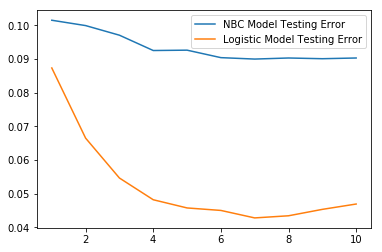

In [6]:
import pickle as cp
import numpy as np
X, y = cp.load(open('voting.pickle', 'rb'))
NBCModel = NBC(['b']*16,2)
CongressModelComparator = ModelComparator(X,y,NBCModel,LogisticModel)
CongressModelComparator.compareModelPerformance()
